Input Embeddings simulation with np

In [61]:
import numpy as np

vocab_size = 5000 # vocabulary size
d_model = 512 # Embeddings dimension
sequence_length = 10 #length of input sequence


embedding_matrix = np.random.randn(vocab_size, d_model).astype(np.float32)
batch_size = 2

input_tokens = np.random.randint(0, vocab_size, size=(batch_size, sequence_length))

input_embeddings = embedding_matrix[input_tokens]

Positional Encoding

In [62]:
def get_positional_encoding(sequence_length, d_model):
    
    positional_encoding = np.zeros((sequence_length, d_model))
    
    for pos in range(sequence_length):
        for i in range(0, d_model, 2):
            denominator = 10000 ** (i / d_model)
            positional_encoding[pos, i] = np.sin(pos / denominator)
            positional_encoding[pos, i + 1] = np.cos(pos / denominator)
    
    return positional_encoding

pos_enc = get_positional_encoding(sequence_length, d_model)

In [63]:
input_embeddings = input_embeddings + pos_enc[None, :, :]

### Self-Attention Mechanism

The self-attention mechanism that we use in transformer is scaled-dot product attention that allows the model to weight the importance of different tokens in the input sequence relative to each other.


1. For each token, we have to compute three vectors:
    Query (Q), Key (K) and Value (V)

    Q: Represents the token being processed

    K: represents the token to be compared with
    
    V: represent the information to be aggregated

We create Q, K and V by multiplying the embeddings by learned weight matrices Wq, Wk and Wv.

In [ ]:
# dimension of queries/key and value 
d_k = 64
d_v = 64 

# Q, K and V are typically derived from the input embeddings using linear transformation. for now, we'll use random
# values to focus on the mechanics of attention

Q = np.random.randn(sequence_length, d_k).astype(np.float32)
K = np.random.randn(sequence_length, d_k).astype(np.float32)
V = np.random.randn(sequence_length, d_k).astype(np.float32)

# Q. K^T
dot_product = np.dot(Q, K.T) #Shape: (sequence_length, sequence_length)

# Q.K^T / sqrt(d_k)
scaled_dot_product = dot_product / np.sqrt(d_k)

#  S = Soft(Q.K^T / sqrt(d_k))
def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=-1, keepdims=True))
    return exp_x / np.sum(exp_x, axis=-1, keepdims=True)

attention_weights = softmax(scaled_dot_product)

# Attention(Q, K, V) = (S)V
attention_score = np.matmul(attention_weights, V)

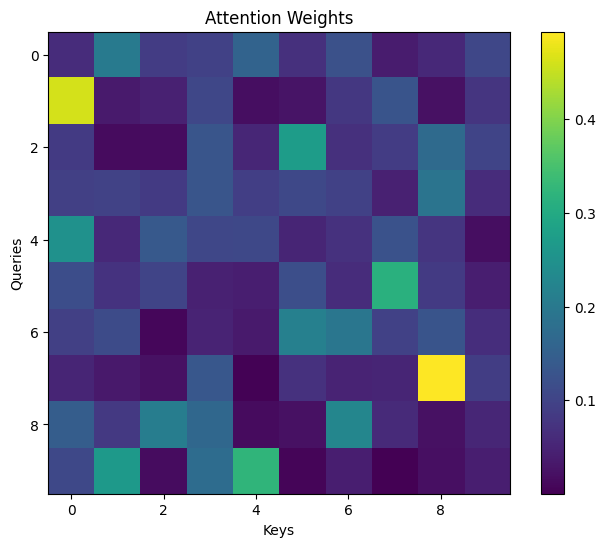

In [65]:
import matplotlib.pyplot as plt

# Plot attention weights
plt.figure(figsize=(8, 6))
plt.imshow(attention_weights, cmap="viridis")
plt.colorbar()
plt.title("Attention Weights")
plt.xlabel("Keys")
plt.ylabel("Queries")
plt.show()

In [66]:
print(attention_score.shape)

(10, 64)


##  Multi-Head Attention

Self-Attention is powerful but using only one attention mechanism has a limitation. 

1. It learns only one type of relationship between words(or tokens)
2. A single attention head may miss out on some dependencies in complex sequence



To overcome this, we split the attention into multiple heads, each attenting to different parts of input independently.
Multi-head attention is that each head is independently parameterized.

In Multi-Head Attention:

1. The input embeddings are linearly projected into multiple sets of queries (Q), Keys(K) and values (V)
2. Each set is processed by separate attention head using Scaled Dot-Production Attention
3. The outputs from all heads are concatenated and passed through a final linear layer to produce the final output.

$$
    MultiHead (Q, K, V) = Concat(head_{1}, head_{2},..,head_{h})W^O
$$

Where:
- $head_{i}$ = $Attention(QW_{i}^Q, KW_{i}^K, VW_{i}^V)$
- $W_{i}^Q, W_{i}^K, W_{i}^K$: Projection matrices for each head
- $W^O$: Final output project matrix
- h: Number of attention heads

In [96]:
num_heads = 8
d_k = d_model // num_heads
d_v = d_model // num_heads


input_embeddings = np.random.randn(sequence_length, d_model).astype(np.float32)

W_Q = np.random.randn(d_model, d_k * num_heads).astype(np.float32)
W_K = np.random.randn(d_model, d_k * num_heads).astype(np.float32)
W_V = np.random.randn(d_model, d_v * num_heads).astype(np.float32)
W_O = np.random.randn(d_model, d_model).astype(np.float32)

print(input_embeddings.shape)
# Project inputs into queries, keys and values
Q = np.dot(input_embeddings, W_Q)
K = np.dot(input_embeddings, W_K)
V = np.dot(input_embeddings, W_V)



print(Q.shape)
print(K.shape)
print(V.shape)


# Reshape to separate heads
Q = Q.reshape(sequence_length, num_heads, d_k)
K = K.reshape(sequence_length, num_heads, d_k)
V = V.reshape(sequence_length, num_heads, d_v)


Q = Q.transpose(1, 0, 2)
K = K.transpose(1, 0, 2)
V = V.transpose(1, 0, 2)

def scaled_dot_product_attention(Q, K, V):
    dot_product = np.matmul(Q, K.transpose(0, 2, 1))
    
    scaled_dot_product = dot_product / np.sqrt(d_k)
    
    attention_weights = softmax(scaled_dot_product)
    output = np.matmul(attention_weights, V)
    return output, attention_weights

def multi_head_attention(Q, K, V):
    attention_outputs, attention_weights = scaled_dot_product_attention(Q, K, V)
    concatenated_outputs = attention_outputs.transpose(1, 0, 2).reshape(sequence_length, d_model)
    final_output = np.dot(concatenated_outputs, W_O)
    return final_output

(10, 512)
(10, 512)
(10, 512)
(10, 512)


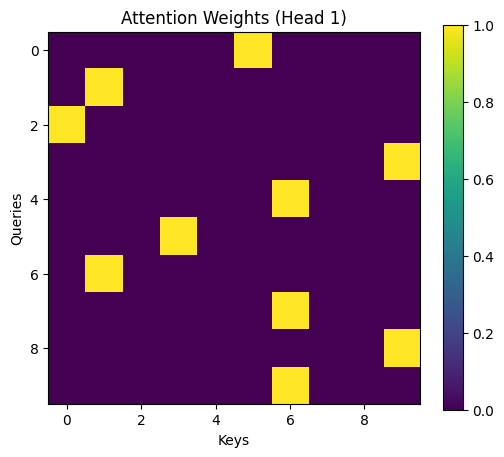

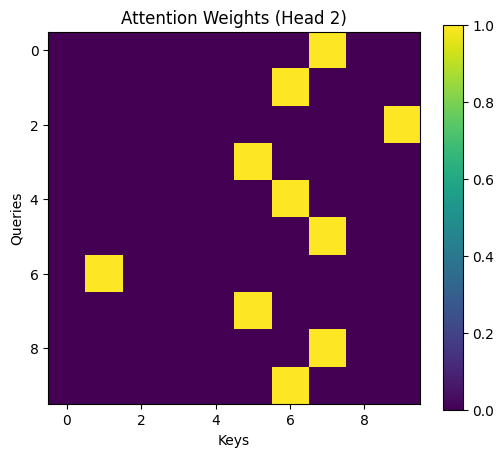

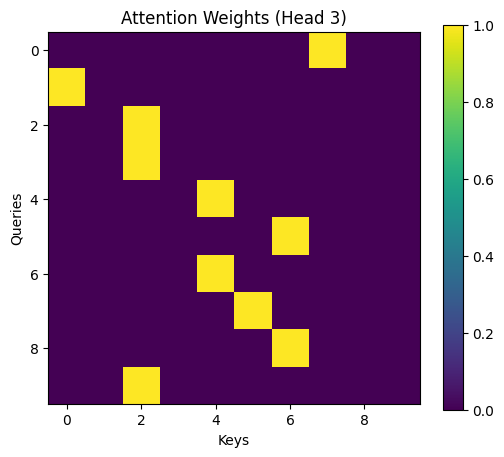

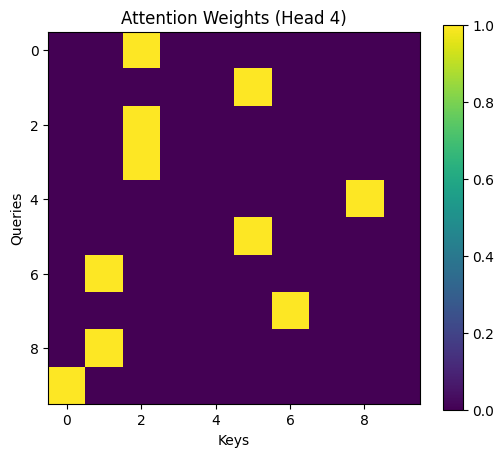

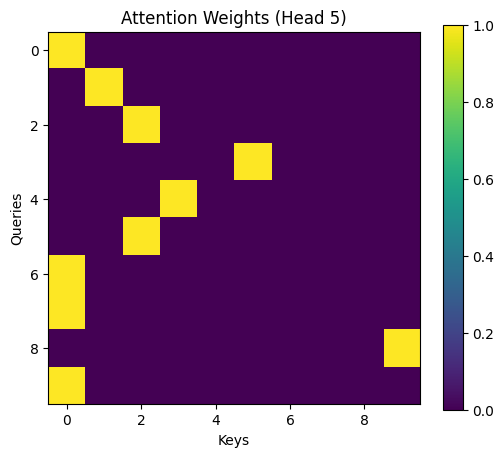

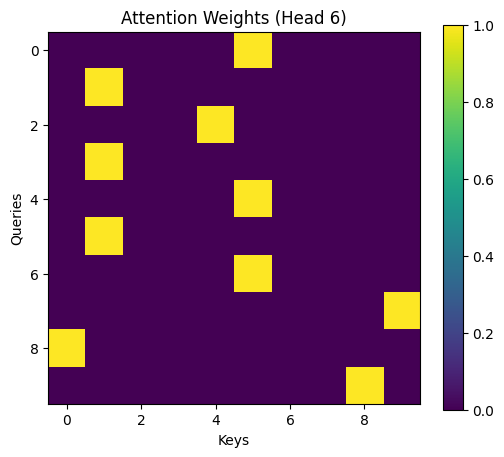

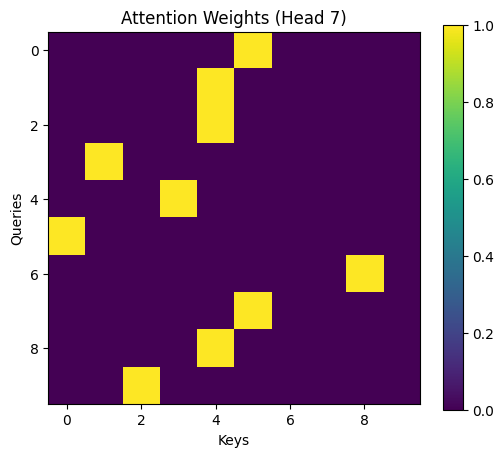

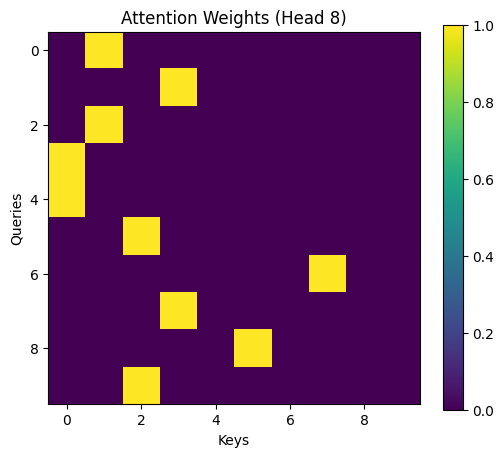

In [84]:
import matplotlib.pyplot as plt

# Plot attention weights for each head
for i in range(num_heads):
    plt.figure(figsize=(6, 5))
    plt.imshow(attention_weights[i], cmap="viridis")
    plt.colorbar()
    plt.title(f"Attention Weights (Head {i+1})")
    plt.xlabel("Keys")
    plt.ylabel("Queries")
    plt.show()

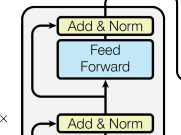

### Add & Norm


1. Residual connection: Add the input to the output of the previous layer.
2. Layer Normalization: Normalize the result across the feature dimension.

In [89]:
def layer_normalization(x, epsilon=1e-6):
    
    mean = np.mean(x, axis=-1, keepdims=True)
    variance = np.var(x, axis=-1, keepdims=True)
    
    normalized_x = (x - mean) / np.sqrt(variance + epsilon)
    
    return normalized_x

In [ ]:
# residual connections, 

# adds the original input of a layer to its output before applying the activation
output = input_embeddings + final_output
normalized_output = layer_normalization(output) # layer norm

##### position wise feed forward network

The feed forward network applies two linear transformations with a ReLU activation in between:

$$
    FFN(x) = max(0, xW_{1} + b_{1})W_{2} + b_{2}
$$



In [104]:
def feed_forward_network(x, d_model, d_ff):
    W1 = np.random.randn(d_model, d_ff).astype(np.float32)
    b1 = np.zeros(d_ff).astype(np.float32)
    W2 = np.random.randn(d_ff, d_model).astype(np.float32)
    b2 = np.zeros(d_model).astype(np.float32)
    
    # activation of neural for non-linearity
    hidden = np.maximum(0, np.dot(x, W1)+b1) 
    
    output = np.dot(hidden, W2) + b2
    
    return output

In [105]:
def encoder_layer(x, Q, K, V, d_model, num_heads, d_ff):
    attention_output = multi_head_attention(Q, K, V)
    
    x = x + attention_output  # Residual connection (Add)
    x = layer_normalization(x) # Norm
    
    ff_output = feed_forward_network(x, d_model, d_ff)
    
    x = x + ff_output  # residual connection (Add)
    x = layer_normalization(x) #layer normalization (Norm)
    
    return x

In [106]:
def transformer_encoder(input_embeddings, d_model, num_heads, d_ff, num_layers):
    x = input_embeddings
    for _ in range(num_layers):
        x = encoder_layer(x,Q, K, V, d_model, num_heads, d_ff)
    return x

In [107]:
x = transformer_encoder(input_embeddings, d_model, num_heads, 2048, 6)

In [109]:
print(x.shape)

(10, 512)


So far, we've covered till enconder in transformers. basically the following block in this picture.

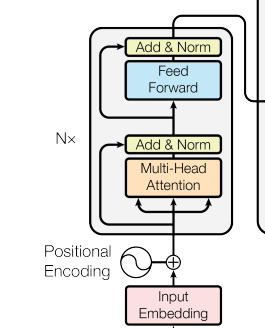